In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_health_indicators_BRFSS2015.csv
/kaggle/input/diabetes-health-indicators-dataset/diabetes_012_health_indicators_BRFSS2015.csv


# **DATA**

**Diabetes_binary**: 0 = no diabetes 1 = prediabetes or diabetes

**HighBP**: 0 = no high BP 1 = high BP (BP = Blood Pressure)

**HighChol**: 0 = no high cholesterol 1 = high cholesterol

**CholCheck**: 0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years

**BMI**: Body Mass Index

**Smoker**: Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes

**Stroke**: (Ever told) you had a stroke. 0 = no 1 = yes

**HeartDiseaseorAttack**: coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes

**PhysActivity**: physical activity in past 30 days - not including job 0 = no 1 = yes

**Fruits**: Consume Fruit 1 or more times per day 0 = no 1 = yes

**Veggies**: Consume Vegetables 1 or more times per day 0 = no 1 = yes

**HvyAlcoholConsump**: (adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes

**AnyHealthcare**: Have any kind of health care coverage, including health insurance, prepaid plans such as HMO, etc. 0 = no 1 = yes

**NoDocbcCost**: Was there a time in the past 12 months when you needed to see a doctor but could not because of cost? 0 = no 1 = yes

**GenHlth**: Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor

**MentHlth**: days of poor mental health scale 1-30 days

**PhysHlth**: physical illness or injury days in past 30 days scale 1-30

**DiffWalk**: Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes

**Sex**: 0 = female 1 = male

**Age**: 3-level age category: 1 - age 18 to 24, 2 - age 25 to 29, 3 - 30 to 34, 4 - age 35 to 39, ... 13 - age 80 or older

**Education**: Education level 1 = Never attended school or only kindergarten 2 = elementary

**Income**: Income scale 1-8 1 = less than 10,000 5 = 35,000 8 = 75,000 or more


In this notebook we are using diabetes binary 5050split health indicators _ BRFSS2015.csv - a clean dataset of 70,692 survey responses to the CDC's BRFSS2015. It has an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes. The target variable Diabetes_binary has 2 classes. 0 is for no diabetes, and 1 is for prediabetes or diabetes. This dataset has 21 feature variables and is balanced.


# **PLAN OF WORK**

1. BMI ---> encode as 1-4 (Underweight, Healthy weight, Overweight, Obese)
2. check if there are any missing values
3. check if data is balanced

**EDA:**

check correlation

make plots



# Data preparation

## Changing continuous feature into a bunch of binary ones (continuous -> categories -> one hot encoding)

### Module imports

In [2]:
from sklearn.preprocessing import OneHotEncoder
from pandas import DataFrame, Series
from typing import Union, Literal

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Continuous -> discrete

In [3]:
def convertBMIIndexToObesityCategory(bmi_index: float, log_warnings: bool = False) -> Literal["Underweight", "Healthy weight","Overweight","Obese"]:
    """
    Converts BMI index to a corresponding obesity category.
    """
    if bmi_index < 9 and log_warnings:
         print(f"Very low BMI index encountered: {bmi_index}.")
    if bmi_index < 18.5:
        return "Underweight"
    if bmi_index < 24.9:
        return "Healthy weight"
    if bmi_index < 29.9:
         return "Overweight"
    if bmi_index > 186 and log_warnings:
         print(f"Very high BMI index encountered: {bmi_index}.")
    return "Obese"
    
def convertBMIIndexColumnToObesityCategories(bmi_column: Series) -> Series:
    """
    Converts BMI indices in column to obesity category.
    """
    category_list = [None] * len(bmi_column)
    for sample_index, bmi_index in enumerate(bmi_column):
        category_list[sample_index] = convertBMIIndexToObesityCategory(bmi_index, log_warnings = True)
    return Series(category_list, dtype = 'category')

### Discrete -> one-hot encoded

In [4]:
def oneHotEncodeBMIColumn(dataset: DataFrame, feature_column_name: str) -> DataFrame:
    """
    Converts BMI column in dataset into series of one hot encoded obesity categories.
    ---
    Parameters:
    
    - `dataset`: DataFrame that contains column to be converted.
    - `feature_column_index`: index of feature's column.
    
    Returns:
    
    A DataFrame with selected column categorized and one hot encoded.
    """
    dataset_has_correct_type: bool = isinstance(dataset, DataFrame)
    if not dataset_has_correct_type:
        dataset_type_name = type(dataset)
        raise TypeError("Dataset has incorrect type; use pandas.DataFrame.")
    try:
        dataset[feature_column_name]
    except KeyError:
        raise IndexError(f"Incorrect feature column name: {feature_column_name}")
    dataset[feature_column_name] = convertBMIIndexColumnToObesityCategories(dataset[feature_column_name])
    encoder = OneHotEncoder(sparse_output = False)
    feature_encoded = DataFrame(encoder.fit_transform(dataset[[feature_column_name]]))
    feature_encoded.columns = encoder.get_feature_names_out([feature_column_name])
    dataset.drop([feature_column_name], axis = 1, inplace = True)
    return (pd.concat([dataset, feature_encoded], axis=1))

In [5]:
# Data import and preprocessing

diabetes_dataset_5050_split = pd.read_csv("/kaggle/input/diabetes-health-indicators-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
diabetes_dataset_5050_split["BMI"] = convertBMIIndexColumnToObesityCategories(diabetes_dataset_5050_split["BMI"])

print(diabetes_dataset_5050_split.head())

   Diabetes_binary  HighBP  HighChol  CholCheck         BMI  Smoker  Stroke  \
0              0.0     1.0       0.0        1.0  Overweight     0.0     0.0   
1              0.0     1.0       1.0        1.0  Overweight     1.0     1.0   
2              0.0     0.0       0.0        1.0  Overweight     0.0     0.0   
3              0.0     1.0       1.0        1.0  Overweight     1.0     0.0   
4              0.0     0.0       0.0        1.0  Overweight     1.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           1.0     0.0  ...            1.0   
1                   0.0           0.0     1.0  ...            1.0   
2                   0.0           1.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      3.0       5

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = diabetes_dataset_5050_split
df.head()



,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,Overweight,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,Overweight,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,Overweight,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,Overweight,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,Overweight,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [8]:
category_mapping = {
    'Underweight': 1,
    'Healthy weight': 2,
    'Overweight': 3,
    'Obese': 4
}

df['BMI_Encoded'] = df['BMI'].map(category_mapping)
df['BMI_Encoded'] = df['BMI_Encoded'].astype(float)
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_Encoded
0,0.0,1.0,0.0,1.0,Overweight,0.0,0.0,0.0,1.0,0.0,...,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0,3.0
1,0.0,1.0,1.0,1.0,Overweight,1.0,1.0,0.0,0.0,1.0,...,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0,3.0
2,0.0,0.0,0.0,1.0,Overweight,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0,3.0
3,0.0,1.0,1.0,1.0,Overweight,1.0,0.0,0.0,1.0,1.0,...,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0,3.0
4,0.0,0.0,0.0,1.0,Overweight,1.0,0.0,0.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0,3.0


In [9]:
df["BMI"].value_counts()


Obese             31444
Overweight        24135
Healthy weight    14460
Underweight         653
Name: BMI, dtype: int64

In [10]:
df["BMI_Encoded"].value_counts()


4.0    31444
3.0    24135
2.0    14460
1.0      653
Name: BMI_Encoded, dtype: int64

In [11]:
df = df.drop(["BMI"], axis=1)

In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   Smoker                70692 non-null  float64
 5   Stroke                70692 non-null  float64
 6   HeartDiseaseorAttack  70692 non-null  float64
 7   PhysActivity          70692 non-null  float64
 8   Fruits                70692 non-null  float64
 9   Veggies               70692 non-null  float64
 10  HvyAlcoholConsump     70692 non-null  float64
 11  AnyHealthcare         70692 non-null  float64
 12  NoDocbcCost           70692 non-null  float64
 13  GenHlth               70692 non-null  float64
 14  MentHlth              70692 non-null  float64
 15  PhysHlth           

In [13]:
# checking for missing values
df.isna().sum()


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
BMI_Encoded             0
dtype: int64

In [14]:
#Checking for duplicates
df.duplicated().sum()

4799

In [15]:
#Drop duplicate rows
df.drop_duplicates(inplace = True)
df.shape

(65893, 22)

In [16]:
df.head()


,Diabetes_binary,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_Encoded
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0,3.0
1,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0,3.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0,3.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0,3.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0,3.0


# ***Exploratory Data Analysis***

We will look at correlation between variables and target (diabetes) to see which variables seem to be most important in the disease prediction. 


In [17]:
# create new column named target
# remove duplicated column ("Diabetes_binary")

df["target"] = df["Diabetes_binary"]
df = df.drop(['Diabetes_binary'], axis=1)
df.head()

,HighBP,HighChol,CholCheck,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,...,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,BMI_Encoded,target
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0,3.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0,3.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0,3.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0,3.0,0.0
4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0,3.0,0.0


In [18]:
# chcek encoding of the variables

for col in df.columns:
    print(col)
    print(df[col].unique())
    print("****************")

HighBP
[1. 0.]
****************
HighChol
[0. 1.]
****************
CholCheck
[1. 0.]
****************
Smoker
[0. 1.]
****************
Stroke
[0. 1.]
****************
HeartDiseaseorAttack
[0. 1.]
****************
PhysActivity
[1. 0.]
****************
Fruits
[0. 1.]
****************
Veggies
[1. 0.]
****************
HvyAlcoholConsump
[0. 1.]
****************
AnyHealthcare
[1. 0.]
****************
NoDocbcCost
[0. 1.]
****************
GenHlth
[3. 1. 2. 4. 5.]
****************
MentHlth
[ 5.  0.  7.  3.  4.  2. 30. 20.  1. 15. 10. 25. 14. 28.  6. 29. 26. 12.
 16. 22. 13.  8.  9. 21. 18. 17. 27. 24. 23. 11. 19.]
****************
PhysHlth
[30.  0. 10.  3.  6.  4. 15.  1.  2. 14.  7. 25. 21. 20.  5.  8. 22. 23.
 29. 12. 18. 28. 26. 24. 27. 11. 13. 16. 17.  9. 19.]
****************
DiffWalk
[0. 1.]
****************
Sex
[1. 0.]
****************
Age
[ 4. 12. 13. 11.  8.  1.  6.  3.  7. 10.  9.  5.  2.]
****************
Education
[6. 5. 4. 3. 2. 1.]
****************
Income
[8. 7. 6. 3. 4. 1. 5. 2.]
*

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

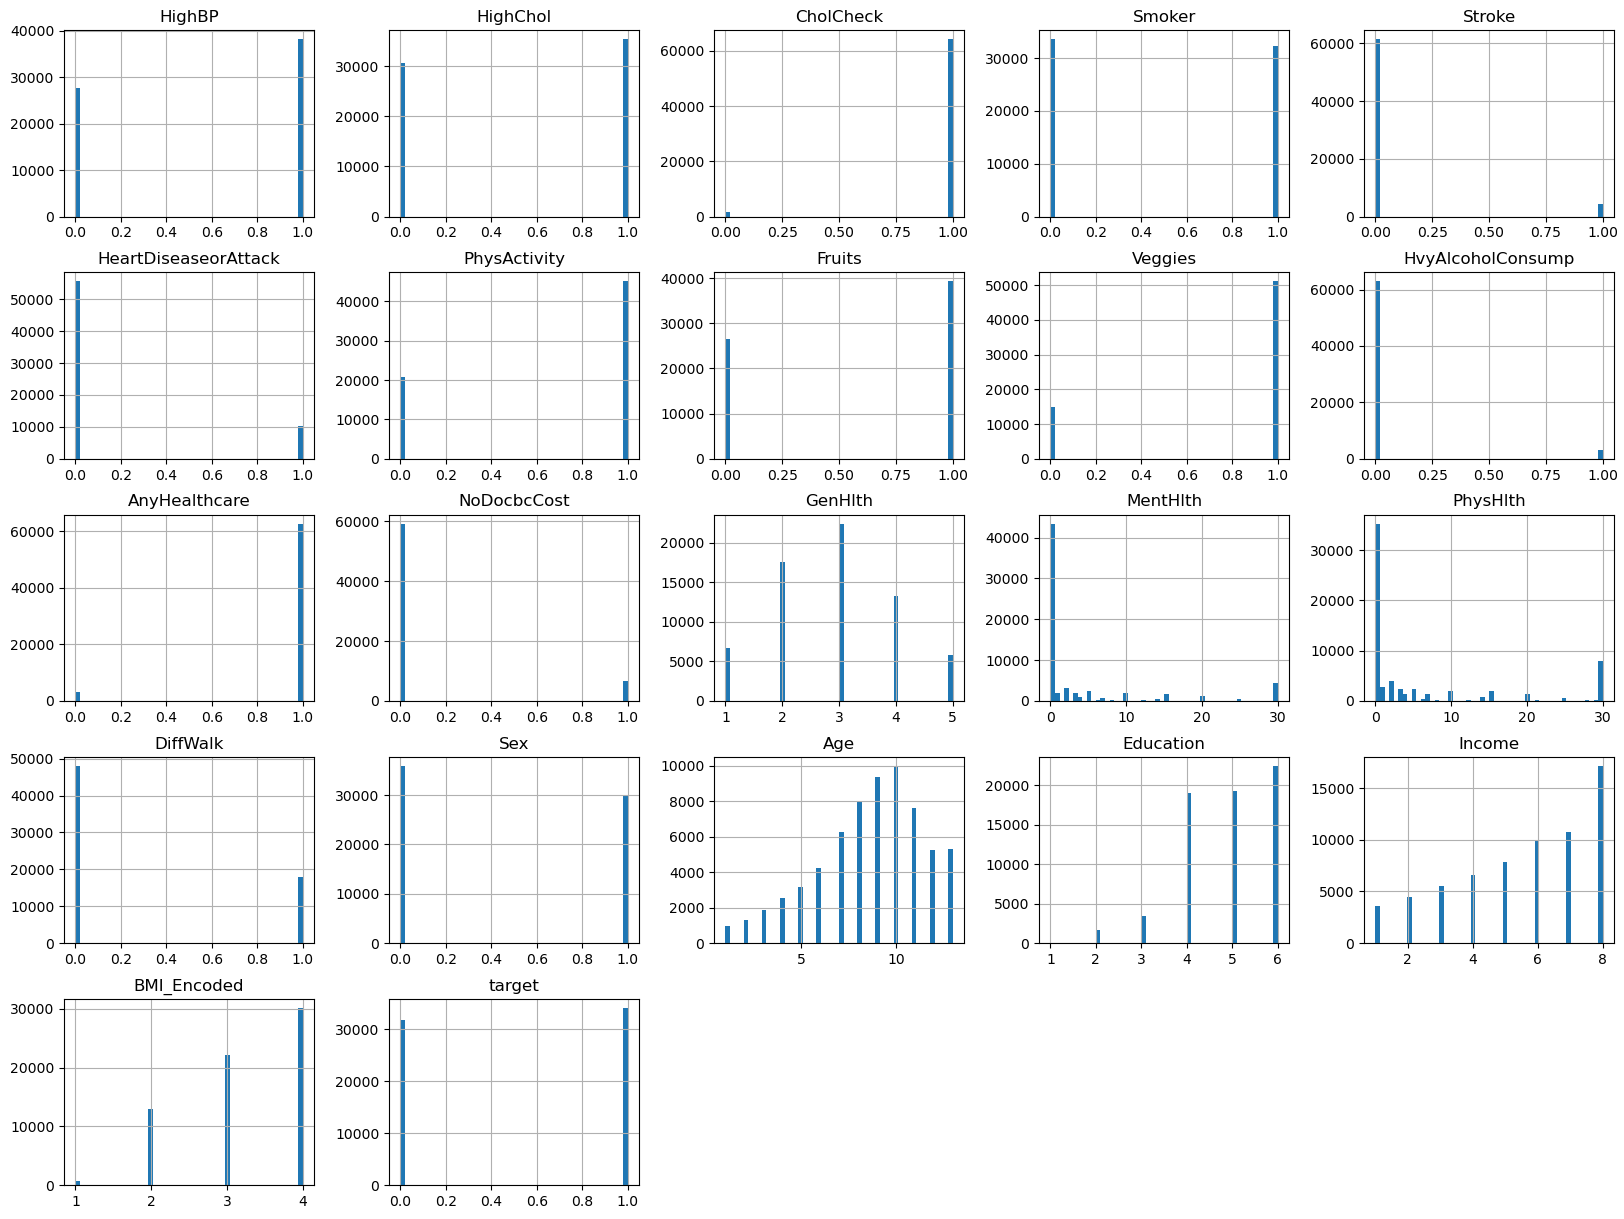

In [20]:
# chcek distribution of values of the variables

%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: >

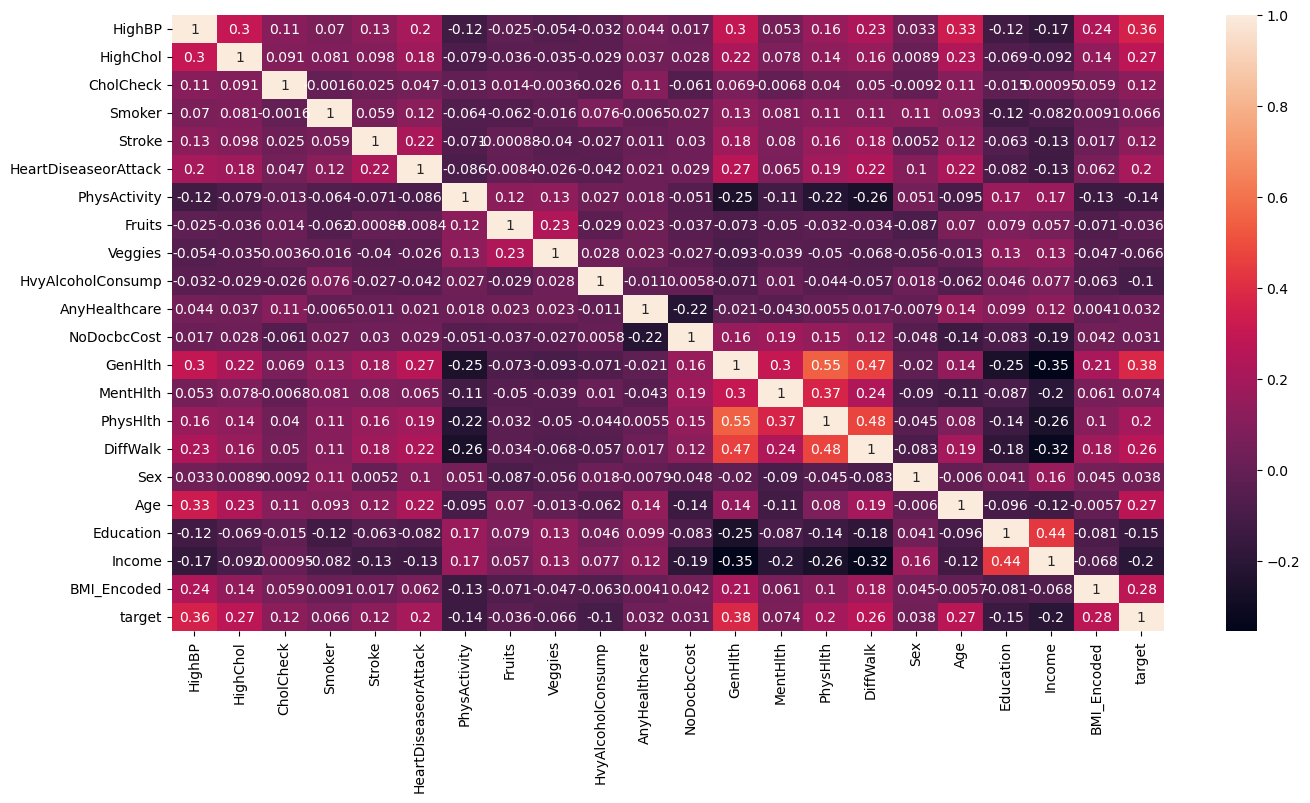

In [21]:
# plot correlation heatmap 

fig, ax = plt.subplots(figsize=(16, 8), dpi=100
                      )
sns.heatmap(df.corr(), annot=True, ax=ax)

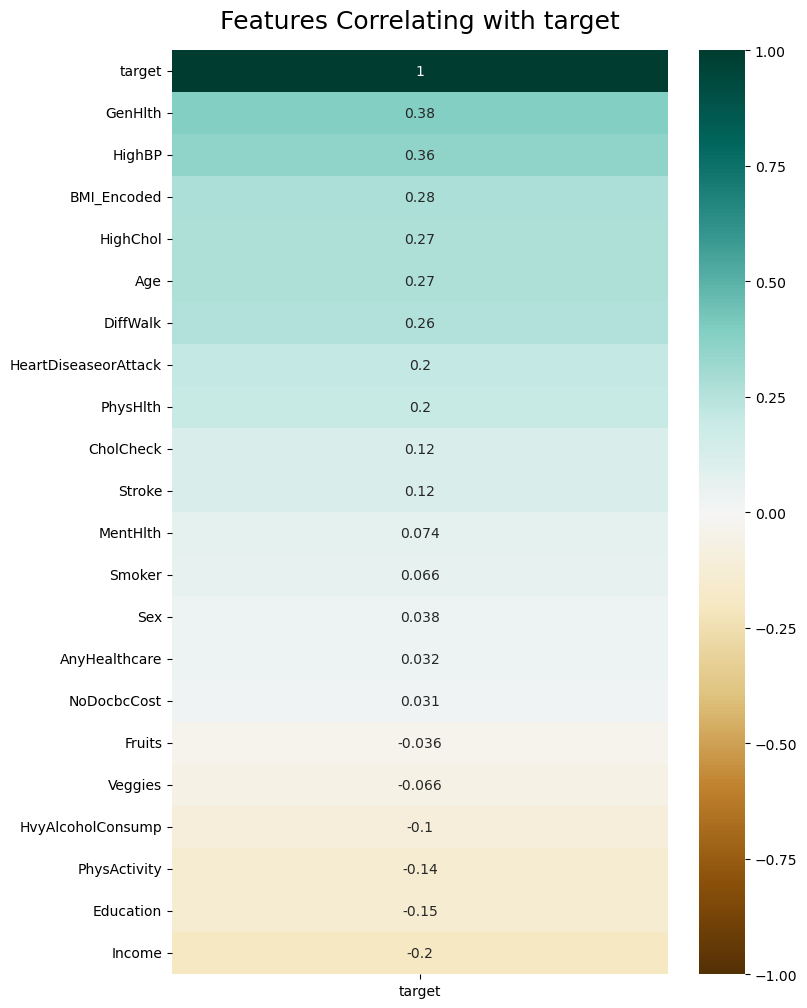

In [22]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['target']].sort_values(by='target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with target', fontdict={'fontsize':18}, pad=16);

**Variables with the highest correlation with Diabetes:**

1. General Health
2. High Blood Pressure
3. BMI - chceck if higher BMI correlates more
4. Income - negatively correlated
5. Education
6. Physical Activity

<Axes: >

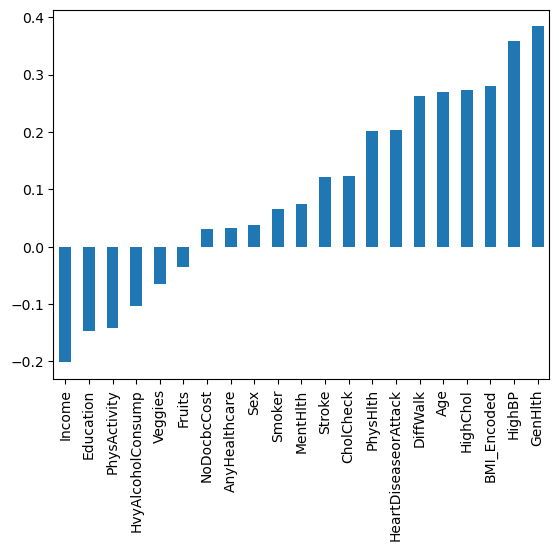

In [23]:
#Plot correlation between the variables and target
df.corr()['target'][:-1].sort_values().plot(kind='bar')

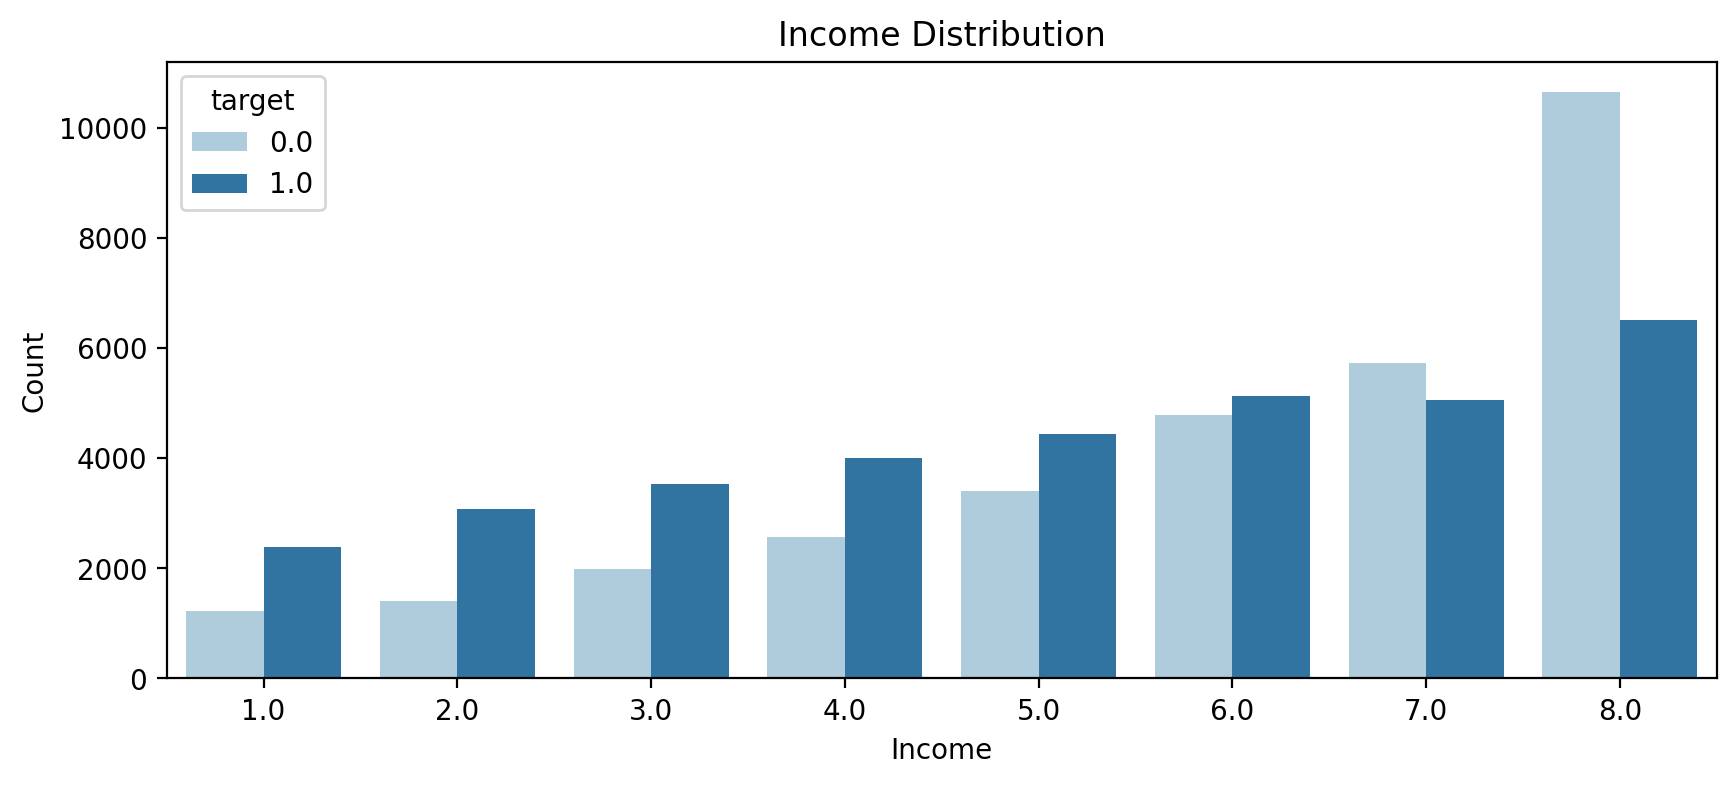

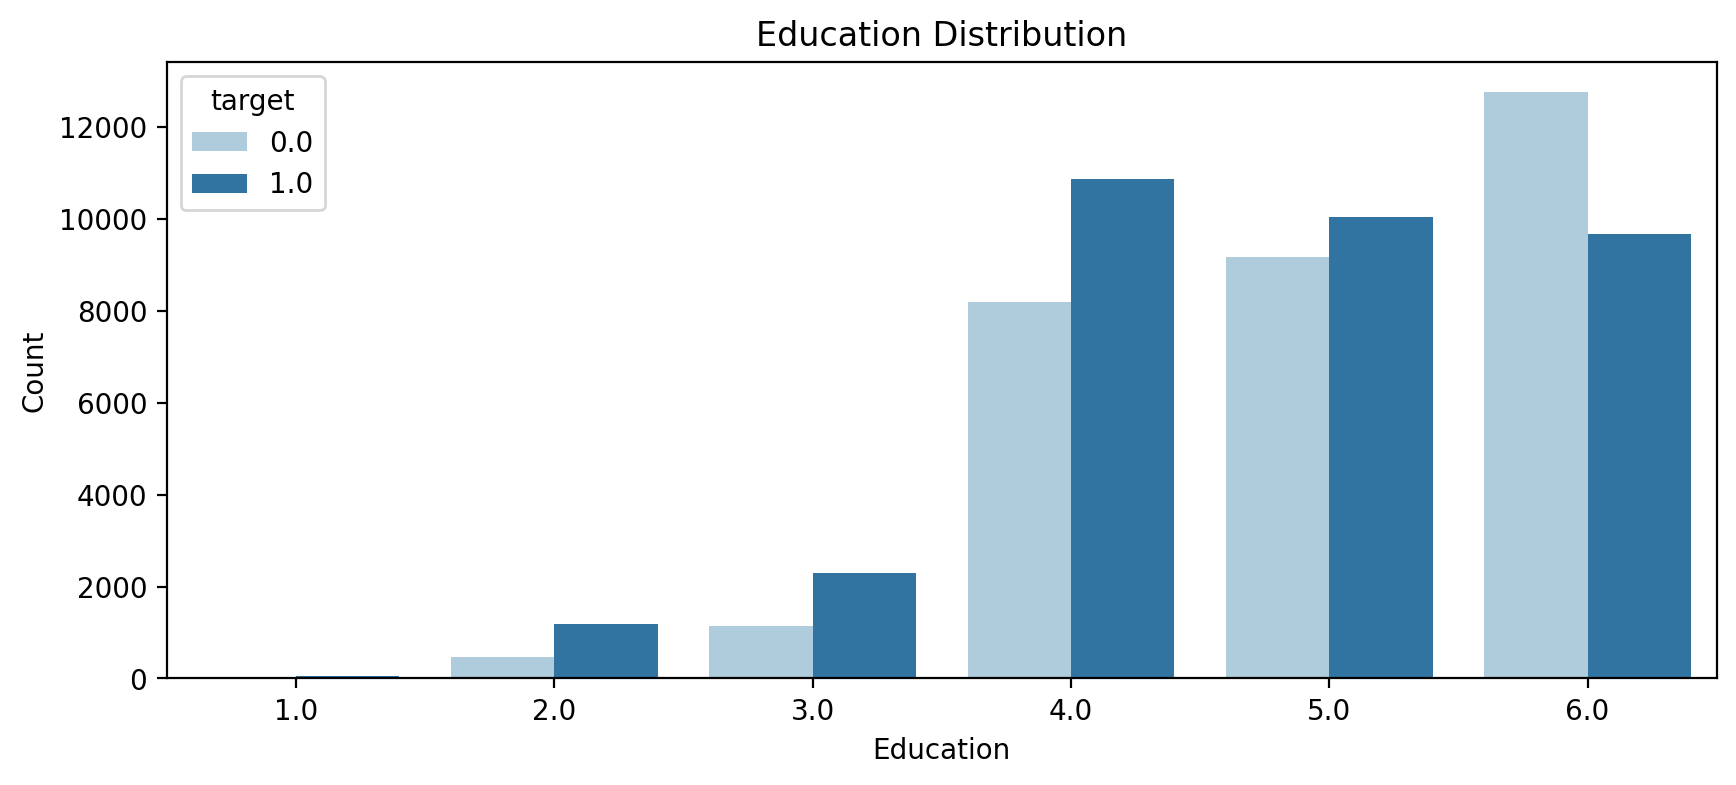

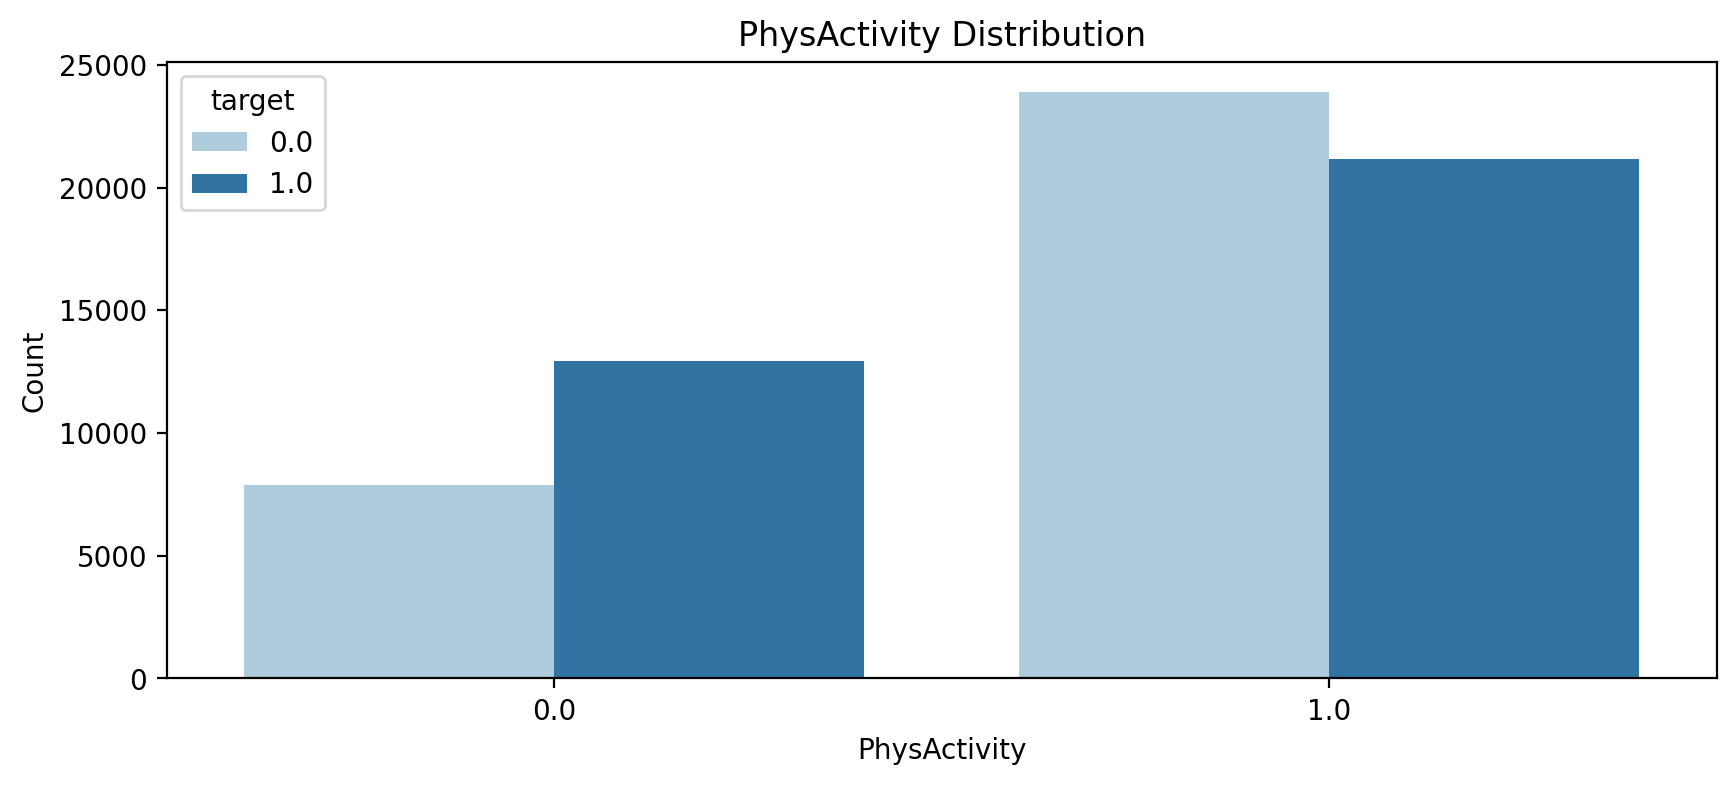

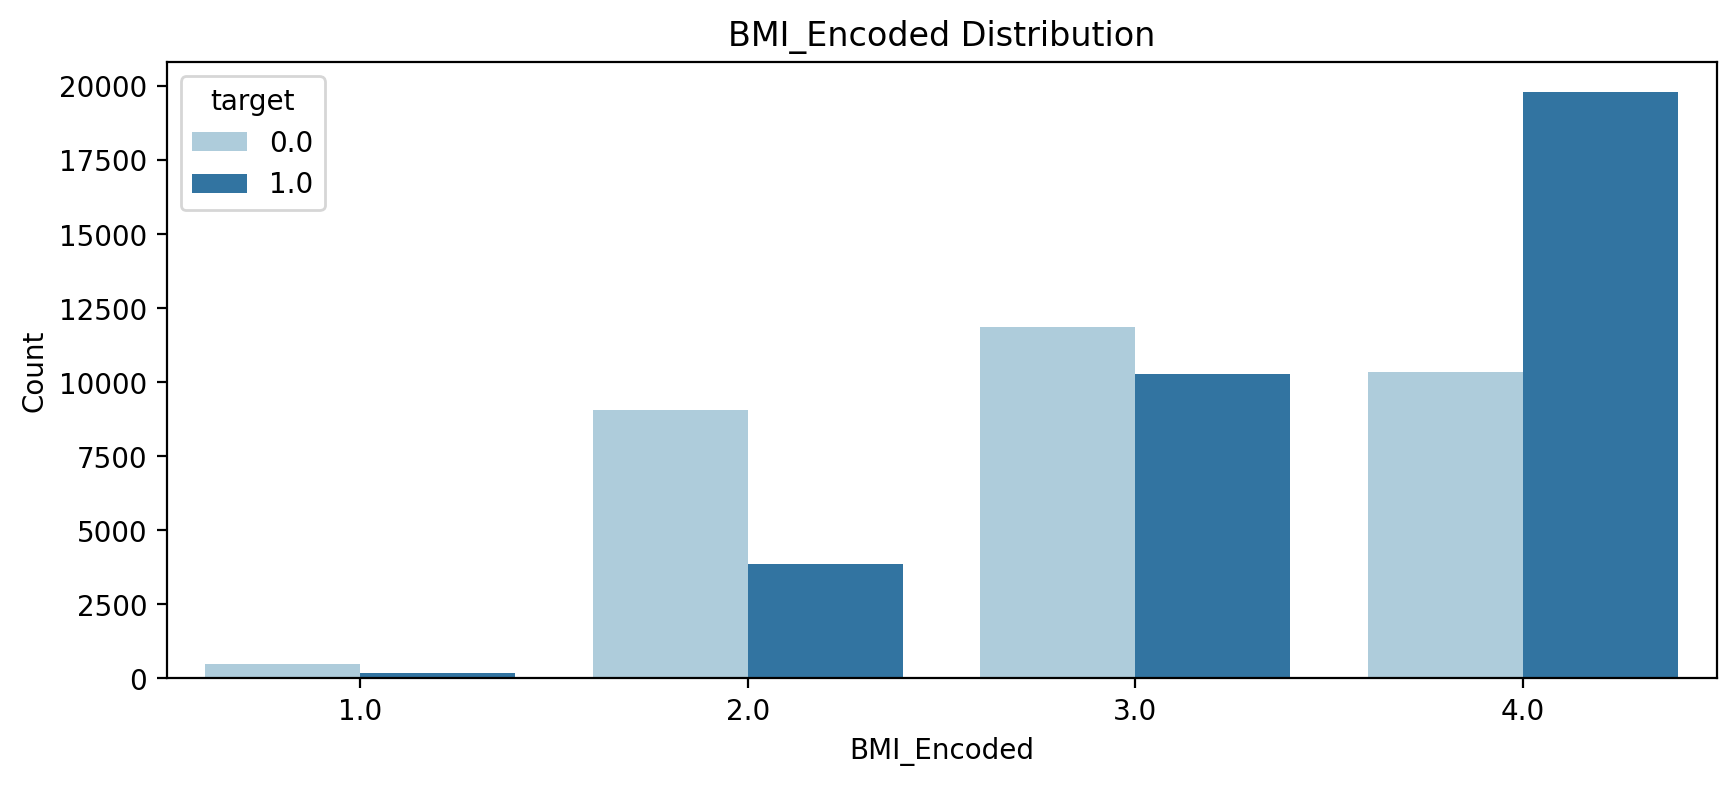

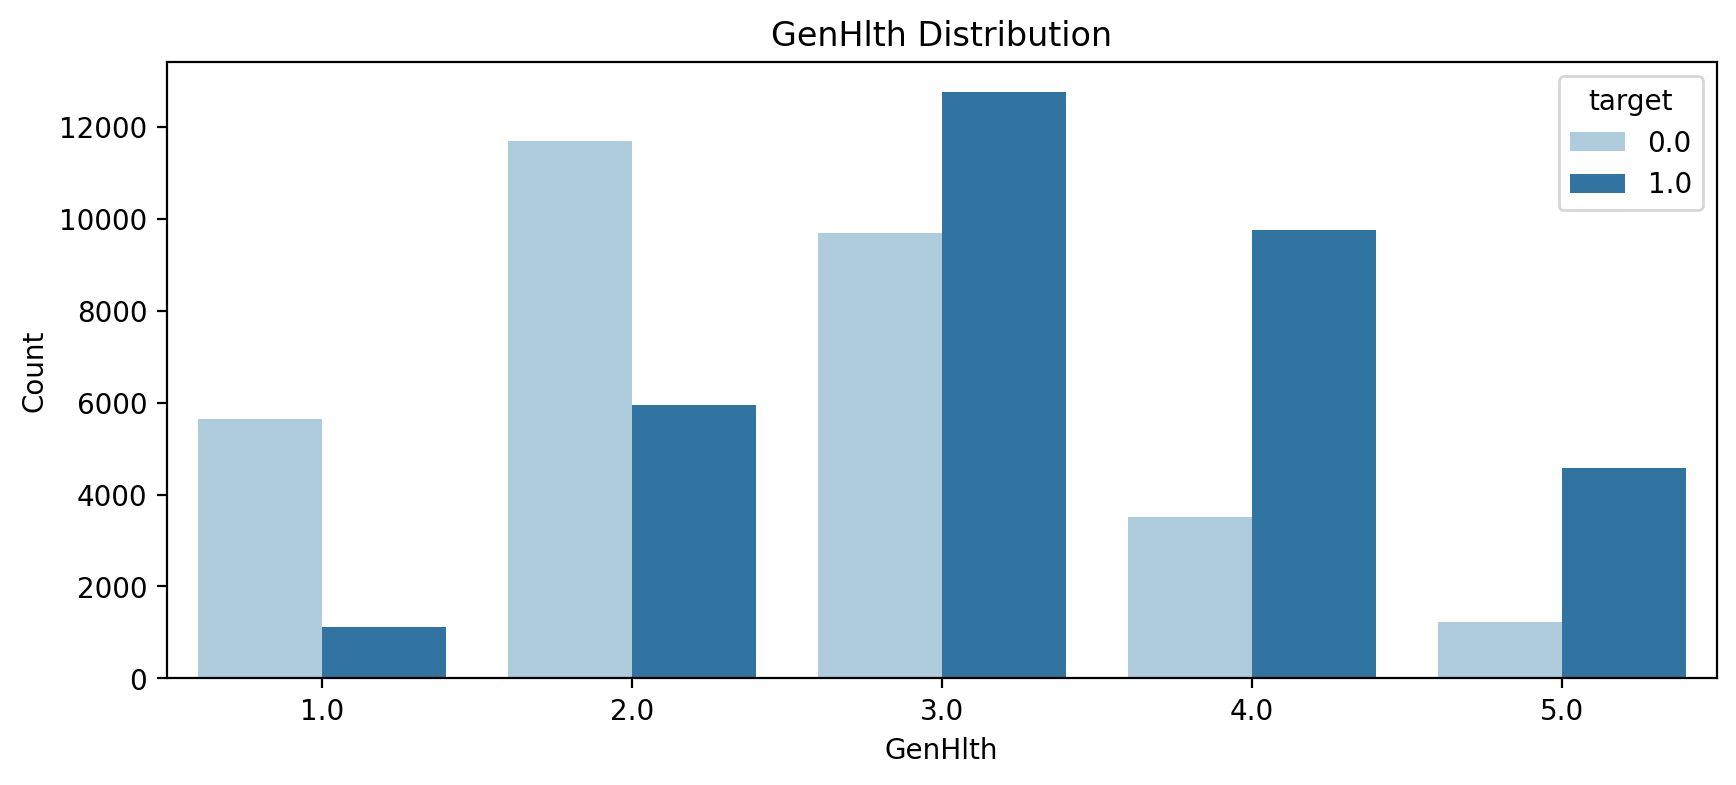

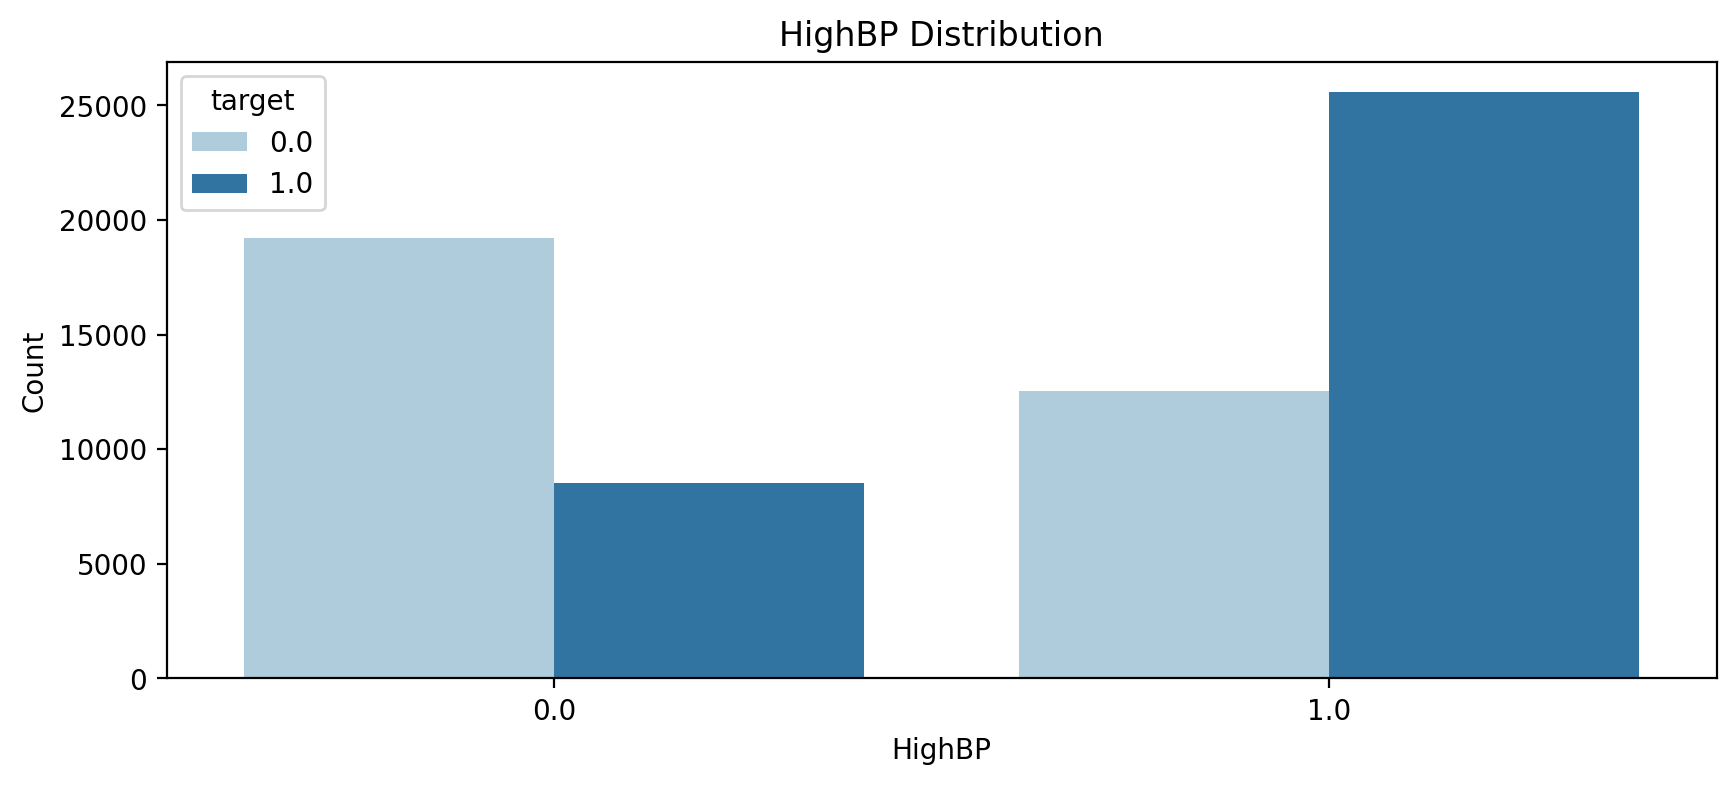

In [24]:
# Look at the counts of the highest correlated variables in subjects with Dibates diagnosis (1) vs subjects with No Dibates diagnosis (0)

high_corr_variables = ["Income", "Education", "PhysActivity", "BMI_Encoded", "GenHlth", "HighBP"]

for var in high_corr_variables:
    plt.figure(figsize=(10,4),dpi=200)
    sns.countplot(x=df[var],data=df,hue='target',palette='Paired')
    plt.title(f'{var} Distribution')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.show()